# Capstone Project: 

## Machine Learning Engineer Nanodegree





Wei-Chuang Chan

## I. Definition

### Project Overview
As post-secondary education become a common experience of commonwealth, the budget of education intitution is often limited and funding is competitive. The project aims to figure out whether allocation of expenditure can help predicting the performance of institution - which is defined by number of award, degree, and certificate granted - as it has been widely used to evaluate the performance of higher education institutes.
http://www.ncsl.org/research/education/performance-funding.aspx
http://www.ed.gov/college-completion

This project is inspired by Udacity's capstone project guidance, and uses dataset downloaded from _Integrated Postsecondary Education Data System Delta Cost Project Database_, which include the data from academy year 1987-1988 to 2012-2013. _The Delta Cost Project Database_ is derived from the Integrated Postsecondary Education Data System (IPEDS) surveys on finance, enrollment, staffing, completions, and student aid, and the data have been translated into analytical formats to allow for longitudinal analyses of trends in postsecondary education with a focus on revenues and expenditure.

### Problem Statement
The question asked with this project is whether expenditure can be used to predict completion number, and if expenditure pattern can make a better predictor for the same target.
Expenditure categories will be retrived from the data set acquired through delta cost project database, 
The goal of this project is to identify if the expenditure pattern will be a better reference to predit high completion number than original data. 

### Metrics
Testing set will be randomly chosen and use 75% of usable data as training set. Principle component analysis will be implemented on training data to find the expenditure pattern, and supervised learning will be conducted with both original training data and scaled and transfromed trainig data in order to compare the performance of both. A regressional predicitve model will be selected and tuned, and finally the performance of the model will be evaluated by R-Squared score as goodness-of-fit. Given the data set use multiple variables, adjusted R-Squared score might be a better choice. Adjusted R-squared is modified R-squared score that will penalize when unhelpful extra predictors were added while R-squared score simply increase with more predictors.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

In [3]:
#Import data for expenditure, and total completion number as performance reference
delta_00=pd.read_csv("Delta_Cost/delta_public_release_00_13.csv")
delta_87=pd.read_csv("Delta_Cost/delta_public_release_87_99.csv")

In [4]:
columns01=['academicyear','has_completions','totalcompletions',
           'instruction01','research01','rschpub01','acadsupp01','studserv01','pubserv01','instsupp01','acadinststud01',
           'opermain01','depreciation01','grants01','auxiliary01','hospital01','independ01',
           'otheroper01','othernon01','other01']
#Other coulmns to be considered.
columns02=['unitid','academicyear','totalcompletions_100fte','instruction02','research02','acadsupp02','studserv02','instsupp02','opermain02','auxiliary02',
           'hospital02','independ02','otheroper02','othernon02','pubserv02','other02']

data_00=delta_00[columns01]
data_87=delta_87[columns01]

In [5]:
i_data=pd.concat([data_00,data_87])

## II. Analysis
### Data Exploration

The dataset retrived from _IPDES_ consists of revenue and expenditure of insitiutes across the country. By selecting data points that contains totalcompletions, the total number of data is 148261. Given the features chosen are all numberical, the data set contains significant amount of null data - which is likely missing data or unreported.

For the data subset taken into this project, a brief explanation of each feature will be provided. The expenditure on salary and wage, total expense reported by FASB, and all subcategories were exluded.

academicyear - the academicyear of data reported.

totalcompletion - the total number of degree, award, certificate gratned of current year. This will be the indicator of perfromance in this project.

has_completion - Indicator of whether totalcompletion has been reported. (0=not reported; 1=reported)

instruction01 - instructional expenses for the institution and excludes administration, operations and maintenance.

research01 - expense used to produce research outcomes excluding operation and maintenance, interest amounts attributed to the research funcion. 

rschpub01 - expense for research and public service of current year

pubserv01 - expense category in order to provide noninstructional services beneficial to individuals and groups external to the institution such as conferences. Operations and maintence,, interest amounts attributed to the research funcion are excluded.

acadsupp01 - expenses to support instruction, research, and public service. This category includes retention, preservation, and display of education materials. Operations and maintenance and interest amounts attributed to the academic support function have been excluded.

studserv01 - expenses associate with admissions, registrar activities, and activities that contribute to students' emotional and physical well-being and to their intellectual, cultural, and social development outside formal instructional program. Operations and maintenance (and interest in the 2009 aligned form) amounts attributed to the student services function have been subtracted.

instsupp01 - expense for day-to-day operational support of the institution such as space management, employee personnel and records. Operations and maintenance and interest amounts attributed to the institutional support is excluded.

acadinststud01 - academic and institutional support and student service total of current year

opermain01 - expenses for operations providing service and maintenance related to campus grounds and facilities. Institutions may optionally distribute depreciation expense to this funcion.

depreciation01 - total depreciation of current year

grants01 - sum of all operating expenses associated with scholarships and fellowships including payment in support of the cost of education or third parties for off-campus housing. Operations and maintenance and interest amounts are excluded.

auxiliary01 - expense of all operating associated with essentially self-supporting operations of the institution such as student health services. The amount of interest is excluded.

hospital01 - operating expenses associated with a hospital operated by the postsecondary institute.

independ01 - expenses associated with operations that are independent of or unrelated to the primary missions of the institution. The amount of interest attributed to the independent operations function are excluded as well as for the expenses of operations owned and managed as investments of the institution's endowment funds.

otheroper01 - All expense other than categories abovem which is completetly discountinued after academy year 2010.

othernon01 - All other non-operating expense of current year
 
other01 - All other expense

Data points that contains totalcompletions value will be included for analysis due to the role of this feature being reference of performance. 

The data set contains significant amount of missing values, the feature contains more than 95% of missing values will be removed, and data points do not contain value for each remaining features will also be removed to avoid bias. The procedue will be taken in order to keep sufficient amount of data while removing data points with missing value first will result in less than 5% usable data.

3 samples will be provided as reference.

In [6]:
#Excluding data with out report of totalcompletion
i_data=i_data[i_data.has_completions !=0 ]

In [7]:
#Check the length of data set
print "Length of data set is {}".format(len(i_data))
print "If missing data is over {}(95% of the data set), remove the feature.".format(len(i_data)*0.95)
print "Quantity of missing data in each category:"
#Count the missing number in each column.
print i_data.isnull().sum()

Length of data set is 148261
If missing data is over 140847.95(95% of the data set), remove the feature.
Quantity of missing data in each category:
academicyear             0
has_completions          0
totalcompletions         0
instruction01        27220
research01          121020
rschpub01            97360
acadsupp01           63485
studserv01           35885
pubserv01           105675
instsupp01           61143
acadinststud01       31421
opermain01           67010
depreciation01      105070
grants01             83608
auxiliary01          71429
hospital01          145935
independ01          144647
otheroper01         143087
othernon01          143017
other01             110643
dtype: int64


In [8]:
for feature in i_data.keys():
    if i_data[feature].isnull().sum() >= (len(i_data)*0.95):
        i_data.drop(feature,axis=1,inplace=True)

In [9]:
i_data.dropna(inplace=True)

In [10]:
i_data.reset_index(drop=True);

In [11]:
y=i_data['totalcompletions']
X=i_data.drop(['academicyear','totalcompletions','has_completions'],axis=1)

In [12]:
display(X.iloc[:,:8].describe(),X.iloc[:,8:17].describe())

,instruction01,research01,rschpub01,acadsupp01,studserv01,pubserv01,instsupp01,acadinststud01
count,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03
mean,1.049301e+08,5.162433e+07,7.157687e+07,2.731878e+07,1.493086e+07,1.995277e+07,2.685790e+07,6.911227e+07
std,1.933580e+08,1.286665e+08,1.664338e+08,4.840374e+07,2.263154e+07,5.016184e+07,4.626784e+07,1.094543e+08
min,9.319400e+04,6.000000e+00,5.750000e+02,2.505109e+04,1.764287e+04,9.800000e+01,4.289300e+04,1.341510e+05
25%,1.934994e+07,3.040892e+05,1.892542e+06,4.355253e+06,4.014000e+06,1.032656e+06,6.178981e+06,1.572695e+07
50%,4.353355e+07,2.428702e+06,7.412453e+06,1.031712e+07,8.127099e+06,3.566569e+06,1.310426e+07,3.321779e+07
75%,1.146129e+08,3.310588e+07,4.750805e+07,2.778494e+07,1.724842e+07,1.357886e+07,2.934451e+07,7.713784e+07
max,3.295913e+09,1.586856e+09,1.891833e+09,5.758219e+08,3.461579e+08,5.444680e+08,8.359294e+08,1.536690e+09


,opermain01,depreciation01,grants01,auxiliary01,other01
count,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03,4.877000e+03
mean,2.129220e+07,2.318188e+07,1.374657e+07,3.626098e+07,8.777288e+06
std,3.824529e+07,6.015664e+07,2.664401e+07,6.262715e+07,4.344284e+07
min,1.009000e+04,7.470000e+02,1.132000e+03,9.600000e+01,-2.382541e+07
25%,4.693000e+06,2.962898e+06,2.184892e+06,4.876133e+06,2.516930e+05
50%,9.812882e+06,6.853124e+06,5.973695e+06,1.373201e+07,1.338295e+06
75%,2.210083e+07,2.010564e+07,1.482055e+07,3.733692e+07,5.383252e+06
max,6.524091e+08,1.794891e+09,4.326828e+08,7.281148e+08,1.360609e+09


In [13]:
np.random.seed(56)
indices=np.random.choice(a=X.index,size=3,replace=False)
sample= pd.DataFrame(X.copy().loc[indices]).reset_index(drop = True)

display(sample.iloc[:,:9],sample.iloc[:,9:])


,instruction01,research01,rschpub01,acadsupp01,studserv01,pubserv01,instsupp01,acadinststud01,opermain01
0,11609795.0,7452948.0,8651239.0,5277338.0,3020257.0,1198291.0,4445021.0,12742616.0,3423547.0
1,211709821.0,20685346.0,41363799.0,49071896.0,27942740.0,20678453.0,57866430.0,134881066.0,33915155.0
2,4918081.0,314873.0,1115521.0,2347665.0,1526700.0,800648.0,1318764.0,5193129.0,2321712.0


,depreciation01,grants01,auxiliary01,other01
0,1846638.0,1279787.0,3570598.0,239095.0
1,37545889.0,37642000.0,97018880.0,315.0
2,1344842.0,781353.0,5038694.0,626991.0


Sample 0 - lower than 25th percentile on instruction, student service, institution support, opermain01, depreciation01, grants01, auxiliary01. More than 25th percentile and lower than 50th percentile on public service, acadinststud01, public service, other01. More than 50 percentile while below average research, rschpub01, acadinststud01. The expenditure of sample 0 falls below average on the lower part of the data set. 


Sample 1 - lower than 25th percentile on other01. More than 50th percentile but lower than average on research, rschpub01. More than 75th percentile on instruction, acadsupp01, student service, public service, instsupp01, acadinststud01, opermain01, depreciation01, grants01, auxiliary01. Sample 1 has higher expense on most categories other than other01 and research. Sample 1 may represent more students or enrollments but fewer allocation of budget on research project. 

Sample 2 - lower than 25th percentile on instructions, rschpub01, acadsupp01, studserv01, pubserv01, instsupp01, opermain01, depreciation01, grants01. Higher than 25th percentile and lower than 50th percentile on research, auxiliary, other01. Sample 2 consist lower expenditure on all categories, and the sample may be reported by an institute of a smaller scale.

The data set will be randomly split into training and testing sets and the former will further explored below.

In [19]:
from sklearn import cross_validation
#Divide label and data and randomly choose training and testing set
X_train, X_test, y_train, y_test=cross_validation.train_test_split(X, y, test_size=0.25, random_state=72)

Identify the outliers in the training set, and remove outlier if significantly impact performance. To avoid deleting relevant data, removal of outlier will be implemented only if performance significantly drops.

In [20]:
#Find the outliers to be removed for each feature
from collections import Counter
c=Counter()
for feature in X_train.keys():
    Q1=np.percentile(X_train[feature], 25)#Find the outliers to be removed for each feature
    Q3=np.percentile(X_train[feature], 75)
    step=1.5*(Q3-Q1)
    outlier_list=[v for v in X_train[~((X_train[feature]>= Q1- step) & (X_train[feature]<=Q3+step))].index.values]
    c.update(X_train[~((X_train[feature]>= Q1- step) & (X_train[feature]<=Q3+step))].index.values)

In [21]:
for n in range(0,len(X_train.columns)+1):
    outliers=[o for o in c.keys() if c[o] > n]
    #Retrieve outliers that shared by more than n features
    corr=X_train.copy().drop(outliers).corr()
    print "Average R2 score after removing {} outliers shared by over {} features:".format(len(outliers),n)
    display(np.mean(corr**2))

Average R2 score after removing 1050 outliers shared by over 0 features:


instruction01     0.569295
research01        0.321940
rschpub01         0.405981
acadsupp01        0.512894
studserv01        0.402690
pubserv01         0.348874
instsupp01        0.485665
acadinststud01    0.575957
opermain01        0.487104
depreciation01    0.493893
grants01          0.283136
auxiliary01       0.385522
other01           0.097303
dtype: float64

Average R2 score after removing 756 outliers shared by over 1 features:


instruction01     0.533581
research01        0.314719
rschpub01         0.389204
acadsupp01        0.431297
studserv01        0.369773
pubserv01         0.287589
instsupp01        0.454156
acadinststud01    0.534339
opermain01        0.464243
depreciation01    0.325571
grants01          0.253692
auxiliary01       0.348054
other01           0.100643
dtype: float64

Average R2 score after removing 671 outliers shared by over 2 features:


instruction01     0.517875
research01        0.306044
rschpub01         0.369372
acadsupp01        0.397353
studserv01        0.348951
pubserv01         0.256279
instsupp01        0.430776
acadinststud01    0.511640
opermain01        0.455323
depreciation01    0.285432
grants01          0.256533
auxiliary01       0.324964
other01           0.107936
dtype: float64

Average R2 score after removing 575 outliers shared by over 3 features:


instruction01     0.518354
research01        0.334234
rschpub01         0.383288
acadsupp01        0.409707
studserv01        0.346661
pubserv01         0.280189
instsupp01        0.428850
acadinststud01    0.516437
opermain01        0.464007
depreciation01    0.268502
grants01          0.258041
auxiliary01       0.315626
other01           0.107016
dtype: float64

Average R2 score after removing 496 outliers shared by over 4 features:


instruction01     0.533735
research01        0.368347
rschpub01         0.414549
acadsupp01        0.433321
studserv01        0.351321
pubserv01         0.309731
instsupp01        0.436521
acadinststud01    0.529493
opermain01        0.484009
depreciation01    0.256241
grants01          0.259173
auxiliary01       0.333819
other01           0.107761
dtype: float64

Average R2 score after removing 442 outliers shared by over 5 features:


instruction01     0.544723
research01        0.398385
rschpub01         0.436811
acadsupp01        0.443174
studserv01        0.358384
pubserv01         0.325789
instsupp01        0.445574
acadinststud01    0.539552
opermain01        0.500071
depreciation01    0.289060
grants01          0.263516
auxiliary01       0.349298
other01           0.113646
dtype: float64

Average R2 score after removing 388 outliers shared by over 6 features:


instruction01     0.527420
research01        0.404231
rschpub01         0.442116
acadsupp01        0.430490
studserv01        0.345924
pubserv01         0.326015
instsupp01        0.424656
acadinststud01    0.526928
opermain01        0.477193
depreciation01    0.183239
grants01          0.266120
auxiliary01       0.348243
other01           0.118025
dtype: float64

Average R2 score after removing 338 outliers shared by over 7 features:


instruction01     0.534633
research01        0.428550
rschpub01         0.465366
acadsupp01        0.448778
studserv01        0.352464
pubserv01         0.350877
instsupp01        0.421665
acadinststud01    0.539258
opermain01        0.489055
depreciation01    0.194939
grants01          0.278037
auxiliary01       0.372439
other01           0.116836
dtype: float64

Average R2 score after removing 293 outliers shared by over 8 features:


instruction01     0.531623
research01        0.440785
rschpub01         0.476540
acadsupp01        0.455928
studserv01        0.352900
pubserv01         0.342584
instsupp01        0.430914
acadinststud01    0.547715
opermain01        0.486718
depreciation01    0.211904
grants01          0.289145
auxiliary01       0.379240
other01           0.122024
dtype: float64

Average R2 score after removing 251 outliers shared by over 9 features:


instruction01     0.540536
research01        0.458459
rschpub01         0.489060
acadsupp01        0.469809
studserv01        0.362178
pubserv01         0.334896
instsupp01        0.446414
acadinststud01    0.556939
opermain01        0.494264
depreciation01    0.226711
grants01          0.293092
auxiliary01       0.392047
other01           0.125066
dtype: float64

Average R2 score after removing 196 outliers shared by over 10 features:


instruction01     0.558039
research01        0.480228
rschpub01         0.508688
acadsupp01        0.487235
studserv01        0.377718
pubserv01         0.321046
instsupp01        0.469446
acadinststud01    0.574224
opermain01        0.500733
depreciation01    0.254309
grants01          0.326183
auxiliary01       0.403834
other01           0.145603
dtype: float64

Average R2 score after removing 133 outliers shared by over 11 features:


instruction01     0.588408
research01        0.504796
rschpub01         0.532958
acadsupp01        0.514989
studserv01        0.413537
pubserv01         0.322108
instsupp01        0.504559
acadinststud01    0.597637
opermain01        0.511166
depreciation01    0.282527
grants01          0.373882
auxiliary01       0.403398
other01           0.145415
dtype: float64

Average R2 score after removing 65 outliers shared by over 12 features:


instruction01     0.607077
research01        0.498291
rschpub01         0.519474
acadsupp01        0.530830
studserv01        0.473599
pubserv01         0.315899
instsupp01        0.523277
acadinststud01    0.614236
opermain01        0.518044
depreciation01    0.322407
grants01          0.424930
auxiliary01       0.387391
other01           0.160919
dtype: float64

Average R2 score after removing 0 outliers shared by over 13 features:


instruction01     0.683905
research01        0.623290
rschpub01         0.639168
acadsupp01        0.618753
studserv01        0.568322
pubserv01         0.406323
instsupp01        0.623052
acadinststud01    0.697260
opermain01        0.623020
depreciation01    0.423482
grants01          0.559248
auxiliary01       0.485488
other01           0.262882
dtype: float64

In [22]:
#Remove 0 outlier shared by over 13 feature
outliers=[o for o in c.keys() if c[o] >= 13]

In [23]:
X_train=X_train.copy().drop(outliers)
y_train=y_train.copy().drop(outliers)

Visualize the correlation between features after removal of outliers. Instruction01 appears to have high correlation with other features, and other expenditure has low correlation with any other features. Features including depreciation01 and pubserv01 have no significant correlation with most other feature in general, but pubserv01 has more than 0.5 of correlation with research01 and rschpub01. Features studserv01, grants01, and auxiliary01 have high correlation with around half of the other features but also show low correlation with the other half of the features.

As the plot shows, instruction is highly correlated with nearly all kinds of expenditure, and so does research expense. While other01, pubserv01, and depreciateion01 could be the most distinguishable features among all.


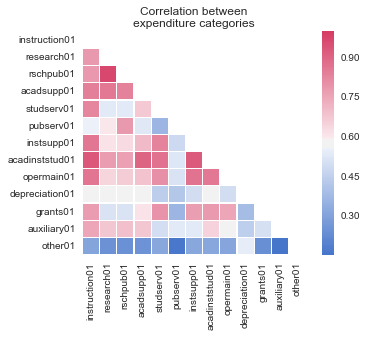

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

#Visualize the correlation for each feature pair
%matplotlib inline
corr=X_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255, 2, as_cmap=True)
sns.set_style("whitegrid")
sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=1,
            square=True,
            linewidths=.2,
           )
plt.title('Correlation between\nexpenditure categories');

### Algorithms and Techniques

The tasks of the project including finding the expenditure pattern, and compare the performance of prediction between expenditure pattern and original expenditure. Principle Component Analysis(PCA) will be implemented and the componenet will be used to represent expenditure allocation, and expenditure pattern. Prior to PCA transformation, a copy of training data will be scaled before fit and transform via PCA. The dimensions acquired through PCA will be used to represent expenditure patterns in the following supervised learning phase.

In the second phase, 3 models will first be compared by adjusted R-squared score and time cost. The model in the selection pool includes Decistion Tree Regressor, Nearest Neighbor Regressor, and Support Vector Regressor. A k-fold validation will be used to evaluate the performance of model. The model with best estimator will be fit by whole training set and transformed training set, and the performance to predict testing set will be used to determine whether expenditure pattern makes better predictor of completion number.

Transforming data accompanies loss of information while using principle components instead of original expenditure may reduce the dimensions of data set. By comparing the time spent and performance of model trained via different data, the goal of this project is to find the better approach to predict performance of higher education institute.

A randomly selected sample set will be present as a reference.

### Benchmark
The aim is to compare the performance of model on original data and pca transformed data, and the performance score of model trained by original data will be the benchmark comparing with transformed version. If there are null value generated in the transformation, the data point contains the value.

## III. Methodology
### Data Preprocessing

Features are selected for analysis as stated above, among all feature taken. As discovered in data exploration, the data set contains great amount of missing data. The features have more than 95% of missing value will also be removed. To obtain the most complete data from the remaining data, any data contains missing value are removed on the next step. The effect of outliers will be discussed and decided whether to be deleted or not.

Prior to PCA analysis and transformation, the log of data set is taken and standardized. During the tranformation process, any data point found to have null value will be removed.

To properly transform and use testing set, there are several data points that contains infinity value, which cannot be processed by PCA, have to be removed.

### Implementation

After preprocessing, the log of data set will be taken and standardize, and it will go through PCA analysis to retrive components to be used as alternative data. Regressional models will be fitted to transformed data and original data set and compared by their adjusted R2 score and time cost. The best performed model will go through grid search CV in order to be tuned.

### Refinement

DecisionTreeRegressor is chosen as the predictive models for both data set, and tuned for both original training data and transformed data. The final model tuned for original data shows adjusted R2 score of 0.9438, and R2 score of model trained with transformed data is 0.8769. While untuned model has 0.9330 on original data and 0.8677 on transformed data.

In [77]:
import sklearn.cross_validation
import sklearn.tree
#Test the correlation to predict a feature with other features.
def adj_r2_score(score,predictors,datalength):
    adj =1-((1-score)*(datalength-1))/(datalength-predictors-1)
    return adj

def feature_trial(feature,data):
    copy=data.copy()
    copy.drop([feature],axis=1,inplace=True)
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(copy, data[feature], 
                                                                                 test_size=0.25,
                                                                                 random_state=15)
    regressor=sklearn.tree.DecisionTreeRegressor(random_state=20)
    regressor.fit(X_train,y_train)
    r2score=np.round(regressor.score(X_test,y_test),6)
    score=adj_r2_score(r2score,len(X_test.keys()),len(X_train)+len(X_test))
    print feature,"", score
for feature in X_train.columns:
    feature_trial(feature,X_train)

instruction01  0.922216070411
research01  0.989391549874
rschpub01  0.990695908634
acadsupp01  0.919725748533
studserv01  0.860663380553
pubserv01  0.914030717519
instsupp01  0.933201781224
acadinststud01  0.945391515507
opermain01  0.798019042749
depreciation01  0.249776989103
grants01  0.605230804694
auxiliary01  0.20850206119
other01  0.464943006706


In [26]:
#Examine skewness and kurtosis of data
import scipy.stats
for feature in X_train.keys():
    print "{} - Skewness={}, Kurtosis={}".format(feature, scipy.stats.skew(X_train[feature]),scipy.stats.kurtosis(X_train[feature]))


instruction01 - Skewness=4.4254644047, Kurtosis=31.6198159444
research01 - Skewness=4.074545208, Kurtosis=20.6797411175
rschpub01 - Skewness=3.62722504849, Kurtosis=15.4626175762
acadsupp01 - Skewness=4.3900468167, Kurtosis=28.9676503532
studserv01 - Skewness=6.97349015872, Kurtosis=89.9846399792
pubserv01 - Skewness=6.15032531151, Kurtosis=52.1668627597
instsupp01 - Skewness=6.69849471103, Kurtosis=82.8179385912
acadinststud01 - Skewness=4.61414444814, Kurtosis=36.6045811205
opermain01 - Skewness=6.35393162703, Kurtosis=69.7684871674
depreciation01 - Skewness=18.5974627524, Kurtosis=518.736152528
grants01 - Skewness=6.25855709845, Kurtosis=75.8313763876
auxiliary01 - Skewness=4.70040563432, Kurtosis=35.3906701925
other01 - Skewness=32.4092472673, Kurtosis=1433.22147145


Normal distribution has 0.03 skewness and 2.96 kurtosis.
The shape of distribution of features are all positively skewed, and the data points tend to sit within a narrow range and resulted high kurtosis. 

In [27]:
#Implement unsupervised learniing with training dataset
X_log=np.log(X_train.copy())
X_log_sample=np.log(sample.copy())

In [28]:
from sklearn import preprocessing
X_log_norm=(X_log - X_log.mean()) / X_log.std()
X_log_sample_norm=(X_log_sample - X_log.mean())/X_log.std()

After standardize log data, it is more clear that sample 0 and sample 2 fall on the lower part of the data set and most of sample 1's expenditure exceed 1 standard deviation over mean. 

The scatter matrix of log data also shows the correlation between each pair of features. Intruction again shows strong correlation with many other features. Other01 doesn't appear to have no notable correlation with others.
#TODO:Elaborate more on scatter matrix.

In [43]:
display(X_log_sample_norm.iloc[:,:10],X_log_sample_norm.iloc[:,10:])

,instruction01,research01,rschpub01,acadsupp01,studserv01,pubserv01,instsupp01,acadinststud01,opermain01,depreciation01
0,-1.091256,0.368907,0.017359,-0.498163,-0.890918,-0.474021,-0.965658,-0.859244,-0.870604,-0.962249
1,1.271572,0.712065,0.727895,1.158429,1.191669,0.901884,1.345644,1.249394,1.064339,1.156318
2,-1.790274,-0.694771,-0.912817,-1.099922,-1.529537,-0.668813,-2.059990,-1.661444,-1.198305,-1.185268


,grants01,auxiliary01,other01
0,-0.914904,-0.697478,-0.492754
1,1.330886,1.252967,-3.018379
2,-1.242612,-0.494048,-0.125615


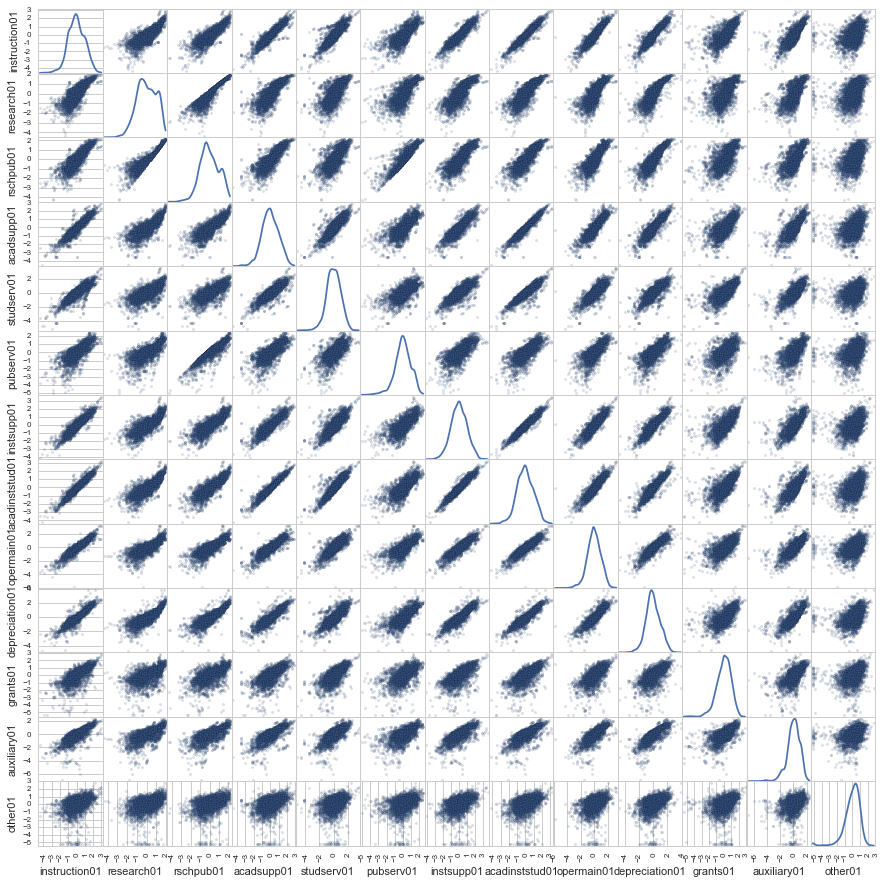

In [30]:
pd.scatter_matrix(X_log_norm, alpha=0.2, figsize=(15,15),diagonal='kde');

In [31]:
X_test_log=np.log(X_test.copy())
X_test_log_norm=(X_test_log-X_log.mean()) / X_log.std()

In [33]:
#Drop null that cannot be passed to PCA
train_null=X_log_norm[X_log_norm.isnull().any(axis=1)].index
test_null=X_test_log_norm[X_test_log_norm.isnull().any(axis=1)].index
X_train_log_p=X_log_norm.drop(train_null)
X_train_p=X_train.copy().drop(train_null)
y_train_p=y_train.copy().drop(train_null)
X_test_log_p=X_test_log_norm.drop(test_null)
X_test_p=X_test.copy().drop(test_null)
y_test_p=y_test.copy().drop(test_null);


In [34]:
#Implement Principle Componenet Analysis
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_log_p)
X_train_pca=pca.transform(X_train_log_p)
X_test_pca=pca.transform(X_test_log_p)
pca_samples=pca.transform(X_log_sample)
print np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)

[ 0.7557884   0.82039834  0.86949569  0.90569808  0.93213451  0.95432792
  0.96857803  0.97770112  0.9861964   0.99363135  0.9973327   0.99960897
  1.        ]


In [104]:
X_train_pd=pd.DataFrame(X_train_pca, columns=dimensions)
X_test_pd=pd.DataFrame(X_test_pca, columns=dimensions)

In [41]:
dimensions=["Dimension {}".format(n+1) for n in range(pca.n_components_)]
pca_sample_dataframe=pd.DataFrame(np.round(pca_samples, 6), columns=dimensions)

display(pca_sample_dataframe.iloc[:,:12],pca_sample_dataframe.iloc[:,12:])

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,Dimension 11,Dimension 12
0,-53.950196,-4.962556,-1.284016,-1.369169,1.132020,-0.385310,1.369118,-0.046701,0.061565,-1.256130,0.272243,0.053291
1,-61.429012,2.760287,-1.550645,-3.306992,2.053972,-0.263478,0.078552,-0.450186,0.453287,-0.862207,0.693054,0.478578
2,-50.939753,-5.853258,-3.234231,-0.924959,1.687402,1.624852,0.273227,-0.157417,-0.245094,-0.552965,0.118808,0.103959


,Dimension 13
0,0.309658
1,0.282052
2,0.455088


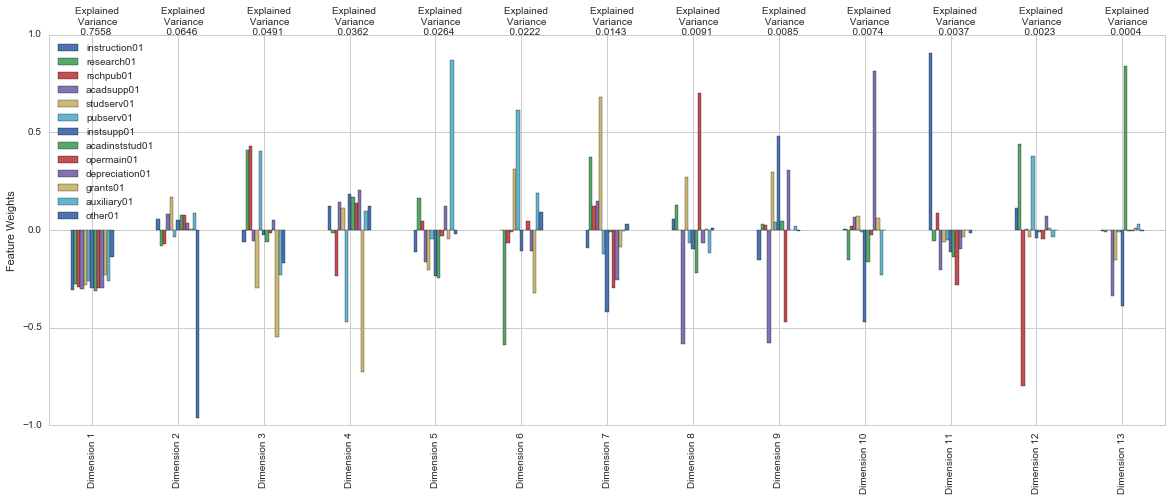

In [105]:

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = X_train_p.keys())
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(pca.n_components_, 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

# Create a bar plot visualization
fig, ax = plt.subplots(figsize = (20,7))

# Plot the feature weights as a function of the components
components.plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature Weights")
ax.set_xticklabels(dimensions)


# Display the explained variance ratios
for i, ev in enumerate(pca.explained_variance_ratio_):
    ax.text(i-0.2, ax.get_ylim()[1], "Explained \n Variance\n  %.4f"%(ev))

# Return a concatenated DataFrame
pca_data=pd.concat([variance_ratios, components], axis = 1)
pca_data;

In [143]:
from time import time
from sklearn.metrics import r2_score
#Count time training model
def training(mod,X_train,y_train):
    start=time()
    mod.fit(X_train,y_train)
    end=time()
    training_time=end-start
    print "Model trained in {:.4f} seconds".format(training_time)
#Return model score
def reg_score(mod, features, target):
    start=time()
    y_pred = mod.predict(features)
    end = time()
    # Print and return results
    predicting_time=end-start
    print "Made predictions in {:.4f} seconds.".format(predicting_time)
    r2=r2_score(y_pred,target)
    adj = adj_r2_score(r2, len(features.keys()),len(features)+len(target))
    print "Adjusted R2 = {:.4f}".format(adj)
def train_predict(mod,X_train,y_train,X_test,y_test):
    print "Training {} with {} training set.".format(mod.__class__.__name__, key)
    training(mod,X_train,y_train)
    print "Training:"
    reg_score(mod, X_train, y_train)
    
    print "Testing:"
    reg_score(mod,X_test,y_test)



## IV. Results
### Model Evaluation and Validation

The final model was chosen by its adjusted R2 score and will be evaluated throuhg kfold cross validation in the next version. The result of model evaluation requires further improvment. Although the model seems to present quite nice score on predicting testing data. The result also goes against initial assumption that transformed data will be a better predictor. An AIC or BIC comparison between the models might be necesary since the transformation of data accompanies with loss of information.

### Justification
As stated above, the performace of transformed data is a weaker predictor comparing with original data set. PCA does not narrow down the dimensionality and further analysis and feature selection might be necessary. The result is not sufficient to solve the initial question by lack of evaluation of model.

In [144]:
from sklearn import neighbors
from sklearn import svm
from sklearn import tree

model_A = neighbors.KNeighborsRegressor()
model_B = tree.DecisionTreeRegressor(random_state=16)
model_C = svm.SVR()
# TODO: Set up the training set sizes
X_train_1 = X_train_p[:1000]
X_train_1p = X_train_pd[:1000]
y_train_1 = y_train_p[:1000]

X_train_2 = X_train_p[:2000]
X_train_2p = X_train_pd[:2000]
y_train_2 = y_train_p[:2000]

X_train_3 = X_train_p[:3000]
X_train_3p = X_train_pd[:3000]
y_train_3 = y_train_p[:3000]


# TODO: Execute the 'train_predict' function for each regressor and each training set size
models = [model_A,model_B,model_C]
train_sets = {'1000':[X_train_1,y_train_1],'1000 PCA':[X_train_1p,y_train_1],
              '2000':[X_train_2,y_train_2],'2000 PCA':[X_train_2p,y_train_2],
              '3000':[X_train_3,y_train_3],'3000 PCA':[X_train_3p,y_train_3]}
for mod in models:
    for key, value in train_sets.iteritems():
        train_predict(mod, value[0], value[1], X_test, y_test)

Training KNeighborsRegressor with 3000 PCA training set.
Model trained in 0.0024 seconds
Training:
Made predictions in 0.0810 seconds.
Adjusted R2 = 0.9625
Testing:
Made predictions in 0.0243 seconds.
Adjusted R2 = -5797.3199
Training KNeighborsRegressor with 2000 PCA training set.
Model trained in 0.0027 seconds
Training:
Made predictions in 0.0859 seconds.
Adjusted R2 = 0.9573
Testing:
Made predictions in 0.0138 seconds.
Adjusted R2 = -7155.3226
Training KNeighborsRegressor with 2000 training set.
Model trained in 0.0015 seconds
Training:
Made predictions in 0.0340 seconds.
Adjusted R2 = 0.9474
Testing:
Made predictions in 0.0239 seconds.
Adjusted R2 = 0.8249
Training KNeighborsRegressor with 3000 training set.
Model trained in 0.0052 seconds
Training:
Made predictions in 0.0719 seconds.
Adjusted R2 = 0.9546
Testing:
Made predictions in 0.0267 seconds.
Adjusted R2 = 0.8377
Training KNeighborsRegressor with 1000 PCA training set.
Model trained in 0.0010 seconds
Training:
Made predicti

### k-NN Regressor

|Data Set|  Training Time  |  Training set predicting  |   Training R2   | Testing set predicting| Testing R2
|:---||:---:|:---:|:---:|:---:|:---:|
|1000|0.0008|0.01|0.9390|0.0116|0.7738
|1000PCA|0.0008|0.0097|0.9512|0.0099|-8260.1630|
|2000|0.0015|0.0331|0.9474|0.0242|0.8249|
|2000PCA|0.0025|0.0866|0.9573|0.0132|-7155.3226|
|3000|0.0031|0.0778|0.9546|0.0280|0.8377|
|3000PCA|0.0023|0.0812|0.9625|0.0224|-5797.5199|

### Decision Tree Regressor

|Data Set|  Training Time  |  Training set predicting  |   Training R2   | Testing set predicting| Testing R2
|:---||:---:|:---:|:---:|:---:|:---:|
|1000|0.0115|0.0009|1.0000|0.0006|0.8112
|1000PCA|0.0111|0.0004|1.0000|0.0002|-0.0054|
|2000|0.0254|0.0005|1.0000|0.0003|0.9145|
|2000PCA|0.0245|0.0005|1.0000|0.0002|-0.0054|
|3000|0.0365|0.0011|1.000|0.0013|0.9107|
|3000PCA|0.0525|0.0008|1.000|0.0002|-0.0054|


### Support Vector Regressor

|Data Set|  Training Time  |  Training set predicting  |   Training R2   | Testing set predicting| Testing R2
|:---||:---:|:---:|:---:|:---:|:---:|
|1000|0.0314|0.0174|-15070307.5436|0.0222|-0.0054|
|1000PCA|0.0658|0.0267|-875.4163|0.0211|-0.0054|
|2000|0.1484|0.0787|-11536618.4363|0.0663|-0.0054|
|2000PCA|0.2192|0.1302|-161.4231|0.0455|-0.0054|
|3000|0.3340|0.1531|-10265069.5852|0.0628|-0.0054|
|3000PCA|0.4343|0.2793|-66.2754|0.0884|-0.0054|

Among all 3 models, Decision Tree Regressor has the highest adjusted R-squared score and grid search will be implemented to obtain best estimator.

In [170]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

def fit_model(X,y):
    cv_sets= ShuffleSplit(X.shape[0],test_size = 0.25, random_state = 50)
    regressor = tree.DecisionTreeRegressor()
    params= {
             'min_samples_split':[2,4,6], 
             'min_weight_fraction_leaf':[0.0,0.1,0.5]
    }
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor,params,scoring=scoring_fnc,cv=cv_sets)
    g = grid.fit(X, y)

    return g.best_estimator_

In [171]:
final_model=fit_model(X_train_p,y_train_p)
print final_model

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.5, presort=False, random_state=None,
           splitter='best')


In [174]:
final_model_pc=fit_model(X_train_pd,y_train_p)
print final_model_pc


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.5, presort=False, random_state=None,
           splitter='best')


In [178]:
print "R2 score on testing data of model trained with original data:"
print final_model.score(X_test,y_test);
print "R2 score on testing data of model trained with transformed data:"
print final_model_pc.score(X_test_pd, y_test_p);

R2 score on testing data of model trained with original data:
0.943822553188
R2 score on testing data of model trained with transformed data:
0.876885347296


## V. Conclusion


### Free-Form Visualization
Comparison of the performance can be presented by AUC. 

### Reflection
This project targets to find the principle components of the expenditure of higher education intitutes and used them as a better predictor of performance, which is defined as total number of degree, certificate, and award completion. In the process of the project, it is quite challenging to find a proper benchmark for the model. Also, the evaluation of models is another challenging. 

### Improvement
While predicting the performance of an institute, rather than using expenditure of current year, previous years should be also taken into consideration for any degree, certificate, awards can take longer than an year to be completed.

On the execution part, this project has a great room for improvment by choosing better evaluation metrics and selecting a proper benchmark. I would consider implement AIC and BIC for model evaluation if I know how. Also, since the pca tranformation reduce no dimension, part of the goal failed at that point. With no benefit reducing the features to be analyze, extra transformation causes extra loss of information.

More visualization techinique should be used instead of description by text.